# Large Scale Bayesian Inference of Log-Gaussian Cox Processes with Expectation Propagation for Traffic Density Estimation Problem

Use Environment: lgcp

# Generate road scenario

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from gp import sample_from_GP

In [2]:
# Road geometry
segment_length = 0.2 # meters
n_segments = 100 # number of segments
xs = np.linspace(0, segment_length * n_segments, n_segments)

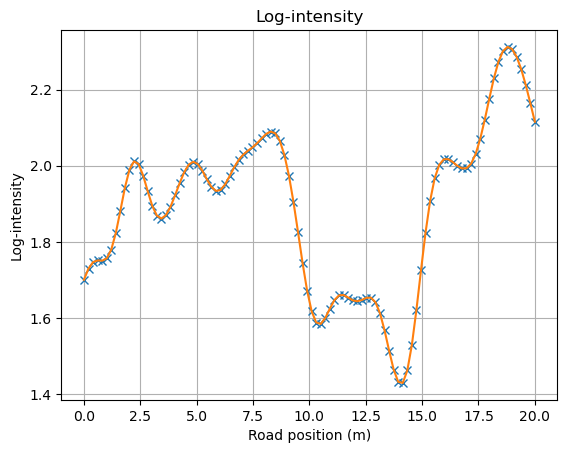

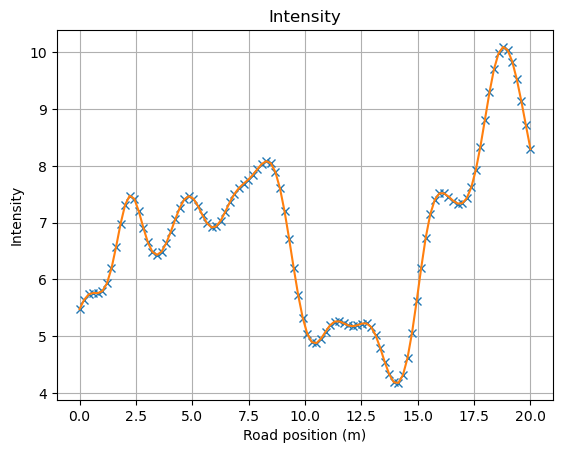

In [3]:
# Sample the log-intensity from GP
np.random.seed(6969)
log_intensity = sample_from_GP(xs, mean=2, var=5e-2, l=1)
plt.plot(xs, log_intensity, 'x')
plt.plot(xs, log_intensity)
plt.xlabel('Road position (m)')
plt.ylabel('Log-intensity')
plt.title('Log-intensity')
plt.grid()
# intensity
intensity = np.exp(log_intensity)
plt.figure()
plt.plot(xs, intensity, 'x')
plt.plot(xs, intensity)
plt.xlabel('Road position (m)')
plt.ylabel('Intensity')
plt.title('Intensity')
plt.grid()

In [4]:
# Sample vehicle positions from intensity using Poisson point process
n_vehicles = []
vehicle_positions = []
for segment in range(n_segments):
    # Sample number of vehicles in segment
    segment_n_vehicles = np.random.poisson(intensity[segment])
    # Add to list
    n_vehicles.append(segment_n_vehicles)
    # Sample vehicle positions in segment
    segment_vehicle_positions = np.random.uniform(0, segment_length, segment_n_vehicles)
    # Add segment offset
    segment_vehicle_positions += segment * segment_length
    # Add to list
    vehicle_positions.extend(segment_vehicle_positions)

# Convert to numpy array
vehicle_positions = np.array(vehicle_positions)
n_vehicles = np.array(n_vehicles)


Number of vehicles in first two segments: 11


(0.0, 0.4)

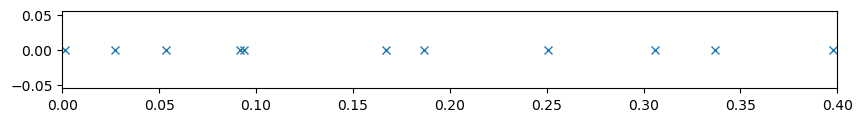

In [5]:
# Plot the first two segment
print('Number of vehicles in first two segments: {}'.format(n_vehicles[0] + n_vehicles[1]))
plt.figure(figsize=(10, 1))
plt.plot(vehicle_positions[:(n_vehicles[0] + n_vehicles[1])], np.zeros_like(vehicle_positions[:(n_vehicles[0] + n_vehicles[1])]), 'x')
plt.xlim((0, 2*segment_length))

# Generate measurements

Text(0.5, 1.0, 'Measurement Positions')

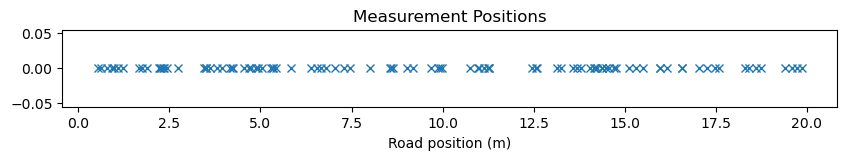

In [6]:
# Generate 100 measurements 
n_measurements = 100
max_road_position = n_segments * segment_length
measurement_positions = np.random.uniform(0, max_road_position, n_measurements)
plt.figure(figsize=(10, 1))
plt.plot(measurement_positions, np.zeros_like(measurement_positions), 'x')
plt.xlabel('Road position (m)')
plt.title('Measurement Positions')

In [7]:
measurement_range = 0.1
measurement_segment_counts = np.zeros((len(measurement_positions), n_segments)) # number of vehicles in each segment for each measurement
measurement_segment_counts_extrapolated = np.zeros((len(measurement_positions), n_segments)) # number of vehicles in each segment for each measurement, extrapolated with the segment length
for i, measurement_position in enumerate(measurement_positions):
    # List all the vehicles in the measurement range
    in_range_bools = np.logical_and(vehicle_positions > measurement_position - measurement_range, vehicle_positions < measurement_position + measurement_range) # boolean array of all vehicles: True if in range
    in_range = vehicle_positions[in_range_bools] # list of vehicle positions in range
    # Count the number of vehicles in each segment
    segment_counts = np.zeros((n_segments,))
    segment_counts_extrapolated = np.zeros((n_segments,))
    for segment in range(n_segments):
        segment_counts[segment] = np.sum(np.logical_and(in_range > segment * segment_length, in_range < (segment + 1) * segment_length))
        if segment_counts[segment] > 0:
            # Find the length of the intersection between the segment and the measurement range
            segment_start = segment * segment_length
            segment_end = (segment + 1) * segment_length
            intersection_start = max(segment_start, measurement_position - measurement_range)
            intersection_end = min(segment_end, measurement_position + measurement_range)
            intersection_length = intersection_end - intersection_start
            # Extrapolate the number of vehicles in the segment using the intersection length
            segment_counts_extrapolated[segment] = segment_counts[segment] * segment_length / intersection_length
    measurement_segment_counts[i, :] = segment_counts
    measurement_segment_counts_extrapolated[i, :] = segment_counts_extrapolated

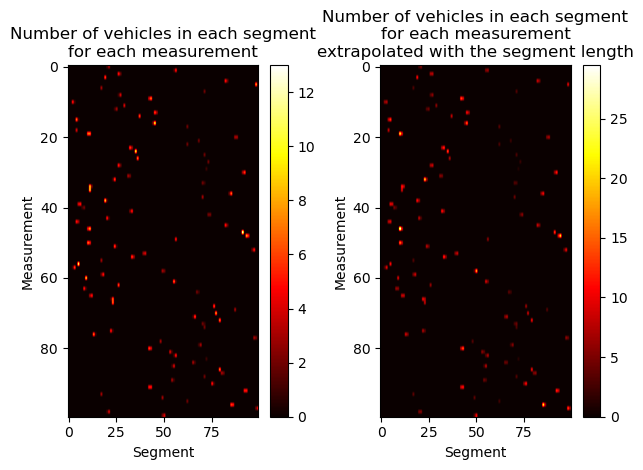

In [8]:
# Visualize the measurements
plt.subplot(1, 2, 1)
plt.imshow(measurement_segment_counts, aspect='auto', cmap='hot')
plt.xlabel('Segment')
plt.ylabel('Measurement')
plt.title('Number of vehicles in each segment\nfor each measurement')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(measurement_segment_counts_extrapolated, aspect='auto', cmap='hot')
plt.xlabel('Segment')
plt.ylabel('Measurement')
plt.title('Number of vehicles in each segment\nfor each measurement\nextrapolated with the segment length')
plt.colorbar()
plt.tight_layout()

# Inference

In [9]:
# Gaussian distribution posterior update
def gaussian_posterior_update(mean1, var1, mean2, var2):
    prec1 = np.linalg.inv(var1)
    prec2 = np.linalg.inv(var2)
    var = np.linalg.inv(prec1 + prec2)
    print('var1 = {}'.format(var1[:3,:3]))
    mean = var @ (prec1 @ mean1 + prec2 @ mean2)
    print('mean1 = {}'.format(mean[:3]))
    return mean, var

def gaussian_posterior_update_list(means, vars):
    mean = means[0,:]
    var = vars[0,:,:]
    for i in range(1, means.shape[0]):
        print('Iter B {}: mean = {}'.format(i, mean[:5]))
        mean, var = gaussian_posterior_update(mean, var, means[i,:], vars[i,:,:])
        print('Iter A {}: mean = {}'.format(i, mean[:5]))
        raise Exception('Stop')
    return mean, var

In [10]:
from gp import gram_matrix
# Expectation Propagation (EP)

# Initialize the EP parameters
# Intractable component approximators / log-likelihood
mu_tildes = np.zeros((n_measurements, n_segments))
var_tildes = np.zeros((n_measurements, n_segments, n_segments))
for i in range(n_measurements):
    var_tildes[i, :, :] = np.eye(n_segments) * 1e-7

# Tractable components approximator / prior
mu_zero = np.ones((n_segments,)) * 2
var_zero = gram_matrix(xs, var=5e-2, l=1)

In [11]:
# Gaussian distribution posterior update
def gaussian_posterior_update(mean1, var1, mean2, var2):
    prec1 = np.linalg.inv(var1)
    prec2 = np.linalg.inv(var2)
    var = np.linalg.inv(prec1 + prec2)
    # print('var1 = {}'.format(var1[:3,:3]))
    mean = var @ (prec1 @ mean1 + prec2 @ mean2)
    # print('mean1 = {}'.format(mean[:3]))
    return mean, var

def gaussian_posterior_update_list(means, vars):
    mean = means[0,:]
    var = vars[0,:,:]
    for i in range(1, means.shape[0]):
        # print('Iter B {}: mean = {}'.format(i, mean[:5]))
        mean, var = gaussian_posterior_update(mean, var, means[i,:], vars[i,:,:])
        # print('Iter A {}: mean = {}'.format(i, mean[:5]))
    return mean, var

max_ep_iterations = 1
for ep_iteration in range(max_ep_iterations):
    # Choose a random measurement index j component to refine
    j = np.random.randint(0, n_measurements)
    # ==================    q_minus_j    ==================
    q_minus_j_means_param = np.concatenate((mu_zero.reshape((1,-1)), np.delete(mu_tildes, j, axis=0)))
    q_minus_j_vars_param = np.concatenate((var_zero.reshape((1, n_segments, n_segments)), np.delete(var_tildes, j, axis=0)))
    mu_q_minus_j, var_q_minus_j = gaussian_posterior_update_list(means = q_minus_j_means_param, vars = q_minus_j_vars_param)
    # ==================    Tilted Distribution    ==================
    measurement_segment_counts_extrapolated_j = measurement_segment_counts_extrapolated[j, :]
    # Segment index is the first non-zero element
    segment_index_j = np.argmax(measurement_segment_counts_extrapolated_j > 0)
    # Number of vehicles in the segment
    nj = measurement_segment_counts_extrapolated_j[segment_index_j]
    # Rename the variables so that they are consistent with the paper
    C_tilde_j = var_q_minus_j
    mu_tilde_j = mu_q_minus_j
    A = segment_length


In [12]:
def laplace_mean_through_fpi(j, C_rho_j, nj, mu, A, max_iter=100, tol=1e-6):
    y = np.zeros_like(mu) # initialize y
    one_j = np.zeros_like(mu)
    one_j[j] = 1
    for iter in range(max_iter):
        y_new = mu + C_rho_j @ ((nj - A*np.exp(y)) * one_j)
        if np.linalg.norm(y_new - y) < tol:
            print('Iteration ended prematurely')
            print('Error: {}'.format(np.linalg.norm(y_new-y)))
            break
        y = y_new
        print('iter: {}, y: {}'.format(iter, y[:5]))
    return y_new

In [13]:
C_rho_j = C_tilde_j[:,j]
laplace_mean_through_fpi(j, C_rho_j, nj, mu_tilde_j, A)

iter: 0, y: [-2.33430719  0.08520367 -2.38638301  0.07191957  0.43289022]
Iteration ended prematurely
Error: 1.036208697025535e-10


array([-2.33430719,  0.08520367, -2.38638301,  0.07191957,  0.43289022,
       -1.57836377, -0.69489436,  0.06430489,  1.29252239, -1.32105478,
       -0.47010802,  0.2321423 ,  0.10801602,  0.1753574 , -1.27447125,
        0.61228956, -0.12077985, -0.31076339,  0.30849895, -0.65935582,
        0.11732501, -0.26133701, -0.97439911,  1.79839263, -0.86747917,
       -0.04117745, -0.05747974,  0.09038675, -0.187904  ,  0.79014057,
       -1.63075587,  1.09555853, -0.52501097,  0.65011704,  0.24114704,
       -1.61395943,  1.39160615, -0.24637139,  0.46975613, -0.4842072 ,
       -0.59305033,  0.53967652,  0.35216859,  0.12600718, -1.04212448,
        1.13745873, -1.47545972,  1.45290908,  0.61247269, -1.81910934,
       -0.68588409,  2.25511478, -0.05476965, -0.0341516 , -3.80282286,
        4.56172426, -1.32210878,  0.79538292, -2.72061048,  1.23793853,
        1.45376357, -0.96001482, -0.43118985,  1.06777279, -3.44283706,
        4.8018841 , -1.2997732 , -1.57952109, -0.71791941,  1.99

In [17]:
print('j = {}'.format(j))
print('nj = {}'.format(nj))
print('mu_tilde_j = {}'.format(mu_tilde_j[:5]))

j = 20
nj = 5.369683926060563
mu_tilde_j = [-2.33430719  0.08520367 -2.38638301  0.07191957  0.43289022]
